Next: https://github.com/arunarn2/HierarchicalAttentionNetworks/blob/master/HierarchicalAttn.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import json_lines

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt
from IPython import display

In [5]:
from sklearn.metrics import classification_report#, accuracy_score
# from sklearn import metrics

In [6]:
import tensorflow as tf
import tensorflow_hub as hub

In [7]:
from keras import backend as K

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Flatten
from keras.regularizers import l2

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


#### Custom Functions

In [8]:
from src.callbacks import PlotCurves
from src.custom_functions import f1_score 
from src.load_data import load_data

### Load Data

In [9]:
train_data, valid_data, test_data = load_data()

#### Number of Sentences

In [10]:
print('Max number of sentences in an article:',
      max([len(article['sentences']) for article in (train_data + valid_data + test_data)]))

Max number of sentences in an article: 58


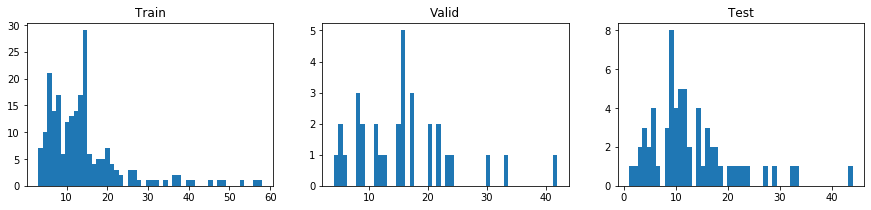

In [11]:
plt.figure(figsize=(15, 3))

plt.subplot(131)
plt.hist([len(article['sentences']) for article in train_data], bins=50)
plt.title('Train')
plt.subplot(132)
plt.hist([len(article['sentences']) for article in valid_data], bins=50)
plt.title('Valid')
plt.subplot(133)
plt.hist([len(article['sentences']) for article in test_data], bins=50)
plt.title('Test')
plt.show()

### Sequential Data 

In [24]:
max_len = 60
n_tags = 2

In [25]:
X_tra = []
for article in train_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_tra.append(new_seq)
X_tra = np.array(X_tra)

In [26]:
X_val = []
for article in valid_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_val.append(new_seq)
X_val = np.array(X_val)

In [27]:
X_test = []
for article in test_data:
    new_seq = []
    for i in range(max_len):
        try:
            new_seq.append(article['sentences'][i]['sentence'])
        except:
            new_seq.append("ENDPAD")
    X_test.append(new_seq)
X_test = np.array(X_test)

In [28]:
X_tra.shape, X_val.shape, X_test.shape

((219, 60), (32, 60), (64, 60))

In [29]:
y_tra = [[sent['label'] for sent in article['sentences']] for article in train_data]
y_tra = pad_sequences(maxlen=max_len, sequences=y_tra, padding="post", value=0)
y_tra = np.array([[to_categorical(y, num_classes=n_tags) for y in sent] for sent in y_tra])

In [30]:
y_val = [[sent['label'] for sent in article['sentences']] for article in valid_data]
y_val = pad_sequences(maxlen=max_len, sequences=y_val, padding="post", value=0)
y_val = np.array([[to_categorical(y, num_classes=n_tags) for y in sent] for sent in y_val])

In [31]:
y_test = np.array([sent['label'] for article in test_data for sent in article['sentences']])

In [32]:
y_tra.shape, y_val.shape, y_test.shape

((219, 60, 2), (32, 60, 2), (822,))

In [33]:
X_tra = X_tra[:218]
y_tra = y_tra[:218]

In [34]:
X_tra.shape, type(X_tra)

((218, 60), numpy.ndarray)

In [35]:
X_val = X_val[:32]
y_val = y_val[:32]

In [36]:
X_val.shape, y_val.shape, type(X_val)

((32, 60), (32, 60, 2), numpy.ndarray)

### Load ELMo

In [37]:
sess = tf.Session()
K.set_session(sess)

In [38]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

### Build Model

In [39]:
def ELMoEmbedding(x):
    embeds = []
    for art in tf.unstack(tf.transpose(x, (1, 0))):
        embeds.append(elmo(tf.squeeze(tf.cast(art, tf.string)), signature="default", as_dict=True)["default"])
    return tf.stack(embeds, 1)

In [40]:
def build_lstm_model():
    
    input_text = Input(shape=(max_len,), dtype="string")
    
    embedding = Lambda(ELMoEmbedding, output_shape=(None, None, max_len, 1024))(input_text)
    
    dns = Dense(512, activation='relu')(embedding)
    
    dns = Dense(256, activation='relu')(dns)
    
    x = Bidirectional(LSTM(units=128, return_sequences=True,
                           recurrent_dropout=0.2, dropout=0.2))(dns)

    x_rnn = Bidirectional(LSTM(units=128, return_sequences=True,
                               recurrent_dropout=0.2, dropout=0.2))(x)

    x = add([x, x_rnn])  # residual connection to the first biLSTM

    out = TimeDistributed(Dense(n_tags, activation="softmax"))(x)
    
    return Model(input_text, outputs=out)

In [75]:
model = build_lstm_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, None, 6 0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, None, 6 524800      lambda_2[0][0]                   
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, None, None, 6 131328      dense_4[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [76]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train Model

In [43]:
## Sequential Model
model.fit(X_tra, y_tra, epochs=10, batch_size=2, validation_data=(X_val, y_val)) 
#           callbacks=[PlotCurves(model_name='elmo_sentence_sequence')])

Train on 218 samples, validate on 32 samples
Epoch 1/10
218/218 [==============================] - 186s 854ms/step - loss: 0.1528 - acc: 0.9239 - val_loss: 0.1051 - val_acc: 0.9490
Epoch 2/10
218/218 [==============================] - 120s 548ms/step - loss: 0.1017 - acc: 0.9556 - val_loss: 0.0993 - val_acc: 0.9531
Epoch 3/10
218/218 [==============================] - 120s 550ms/step - loss: 0.0870 - acc: 0.9609 - val_loss: 0.1088 - val_acc: 0.9526
Epoch 4/10
218/218 [==============================] - 120s 548ms/step - loss: 0.0751 - acc: 0.9657 - val_loss: 0.1012 - val_acc: 0.9542
Epoch 5/10
218/218 [==============================] - 120s 549ms/step - loss: 0.0627 - acc: 0.9727 - val_loss: 0.1141 - val_acc: 0.9557
Epoch 6/10
218/218 [==============================] - 120s 550ms/step - loss: 0.0463 - acc: 0.9802 - val_loss: 0.1523 - val_acc: 0.9432
Epoch 7/10
218/218 [==============================] - 120s 550ms/step - loss: 0.0345 - acc: 0.9870 - val_loss: 0.1485 - val_acc: 0.9557
Epo

### Test

In [44]:
model_preds = model.predict(X_test, batch_size=2)

In [62]:
y_preds = [[np.argmax(lab) for lab in art] for art in model_preds]

In [71]:
y_preds_unpad = []
for ai, art in enumerate(X_test): 
    
    for si, sent in enumerate(art):
        
        if sent != 'ENDPAD':
            y_preds_unpad.append(y_preds[ai][si])

In [74]:
### Sequential Model results
print(classification_report(y_test, y_preds_unpad))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89       616
           1       0.65      0.73      0.69       206

   micro avg       0.84      0.84      0.84       822
   macro avg       0.78      0.80      0.79       822
weighted avg       0.84      0.84      0.84       822

